Author: IP Wing Yan

Date: 16 May 2021

In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt

## Prepare Professions Words

In [2]:
job_list = pd.read_excel("occupation_word_list.xlsx")

In [3]:
job_list

,occupations
0,accountant
1,actor
2,actress
3,air traffic controller
4,architect
...,...
365,writer
366,xylophonist
367,yodeler
368,zookeeper


In [4]:
cleaned_job_list = job_list[job_list.occupations.str.count(' ')==0].drop_duplicates()

In [5]:
# from gensim.scripts.glove2word2vec import glove2word2vec
# glove2word2vec(glove_input_file="glove.840B.300d.txt", word2vec_output_file="glove.txt")

# To load the downloaded glove word embedding in w2v format, which may take some times...
glove = KeyedVectors.load_word2vec_format("glove.txt", binary=False)

In [6]:
processed_job_list = []

for x in cleaned_job_list.occupations:
    if x in glove: processed_job_list.append(x)
        
len(processed_job_list)

287

## Functions for later usage:

In [7]:
def bias_direction(bias1, bias2):
    """
    Returns the two normalized vector directions and a normalized bias direction
    """
    
    twomeans = [sum(glove[w] for w in word)/len(word) for word in (bias1, bias2)]
    vec_directions = [v / np.linalg.norm(v) for v in twomeans]
    vB = vec_directions[0] - vec_directions[1]
    fin_vB = vB / np.linalg.norm(vB)
    
    return vec_directions[0], vec_directions[1], fin_vB

In [8]:
def cos_sim(a, b):
    """
    Returns cosine similarity between two vectors
    """
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [9]:
def association(w, A, B):
    """
    Returns association of a target word w with attribute words, i.e. s(w, A, B)
    w: one target word vector
    A: attribute word vectors
    B: attribute word vectors
    """
    return np.mean(list(map(lambda a: cos_sim(w,a), A))) - np.mean(list(map(lambda b: cos_sim(w,b), B)))

In [10]:
def weat_nscore(X, Y, A, B):
    """
    Returns normalized WEAT score
    X: target word vectors
    Y: target word vectors
    A: attribute word vectors
    B: attribute word vectors

    """
    
    X_association = np.array(list(map(lambda x : association(x, A, B), X)))
    Y_association = np.array(list(map(lambda y : association(y, A, B), Y)))
                         
    mean_diff = np.mean(X_association) - np.mean(Y_association)   
    std = np.std(np.concatenate((X_association, Y_association)))

    return mean_diff / std

In [11]:
def linear_projection(u,v):
    """
    Returns a debiased word vector
    u: the word vector
    v: the bias direction
    """
    
    u = u - np.dot(u,v)*v
    
    return u

# Part 1: Gender Bias

## Step 1: Define Gender Direction

In [12]:
# We will use the he-she word pair as proposed by Bolukbasi et al (2016)
v_he, v_she, vB_gender = bias_direction(['he'], ['she'])

## Step 2: Visualization for Gender Bias

In [13]:
# find out 10 most he-positive-extreme occupation words 
htemp = []

for x in processed_job_list:
    htemp.append(cos_sim(v_he, glove[x]))

he = pd.Series(htemp, index=processed_job_list, name='he')
he.nlargest(n=10)

judge         0.481602
doctor        0.467547
president     0.458380
soldier       0.446679
teacher       0.443727
politician    0.443103
captain       0.437806
cop           0.431660
policeman     0.422934
professor     0.415242
Name: he, dtype: float64

In [14]:
# find out 10 most she-positive-extreme occupation words 
stemp = []

for x in processed_job_list:
    stemp.append(cos_sim(v_she, glove[x]))

she = pd.Series(stemp, index=processed_job_list, name='she')
she.nlargest(n=10)

nurse       0.513825
teacher     0.512202
doctor      0.509170
actress     0.497068
waitress    0.460631
judge       0.448580
singer      0.439919
dancer      0.438895
student     0.425599
maid        0.418461
Name: she, dtype: float64

In [15]:
dots = list(set(he.nlargest(n=10).index) | set(she.nlargest(n=10).index))
scatter = pd.concat([he,she], axis=1).loc[dots]
scatter['bias'] = np.where(scatter.he > scatter.she, 'blue', 'red')

In [16]:
# To be visually fair and clear, we choose five bias=red and five bias=blue to plot
chosen_job1 = ['nurse', 'actress', 'waitress', 'dancer', 'maid', 'judge', 'cop', 'president', 'politician', 'captain']
scatter=scatter.loc[chosen_job1]

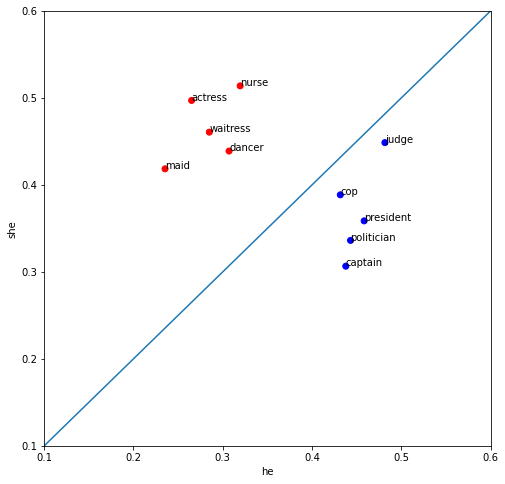

In [17]:
x = scatter.he
y = scatter.she

plt.figure(figsize=(8,8))
plt.scatter(x, y, c=scatter.bias)
plt.xlabel("he")
plt.ylabel("she")
plt.xlim(0.1, 0.6)
plt.ylim(0.1, 0.6)
plt.axline([0,0],[1,1])

for i, txt in enumerate(scatter.index):
    plt.annotate(txt, (x[i], y[i]))

## Step 3: WEAT for Gender Bias

**Target words:**

Male names: John, Paul, Mike, Kevin, Steve, Greg, Jeff, Bill

Female names: Amy, Joan, Lisa, Sarah, Diana, Kate, Ann, Donna
    
**Attrib. words:**

Career words : executive, management, professional, corporation, salary, office, business, career

Family words : home, parents, children, family, cousins, marriage, wedding, relatives

In [18]:
male_names = pd.read_excel("male_name.xlsx", names=['name'], header=None)
male_name_words = [w for w in male_names.name if w in glove]
len(male_name_words)

8

In [19]:
female_names = pd.read_excel("female_name.xlsx", names=['name'], header=None)
female_name_words = [w for w in female_names.name if w in glove]
len(female_name_words)

8

In [20]:
careers = pd.read_excel("career.xlsx", names=['career'], header=None)
career_words = [w for w in careers.career if w in glove]
len(career_words)

8

In [21]:
family = pd.read_excel("family.xlsx", names=['family'], header=None)
family_words = [w for w in family.family if w in glove]
len(family_words)

8

In [22]:
weat_nscore(glove[male_name_words], glove[female_name_words], glove[career_words], glove[family_words])

1.8734031

## Step 4: Debiasing for Gender and Repeat Step 2 & 3

In [23]:
debiased_job1 = []
gender_neutral_job = list(set(chosen_job1) - set(['actress','maid','waitress']))
for w in gender_neutral_job:
    debiased_job1.append(linear_projection(glove[w], vB_gender))

In [24]:
htemp = []

for x in debiased_job1:
    htemp.append(cos_sim(glove['he'], x))
                 
he = pd.Series(htemp, index=gender_neutral_job, name='he')

In [25]:
stemp = []

for x in debiased_job1:
    stemp.append(cos_sim(glove['she'], x))
                 
she = pd.Series(stemp, index=gender_neutral_job, name='she')

In [26]:
de_scatter = pd.concat([he,she], axis=1)
de_scatter['bias'] = np.where(de_scatter.he > de_scatter.she, 'blue', 'red')
new_scatter = pd.concat([de_scatter, scatter.loc[['actress','maid','waitress']]], axis=0)

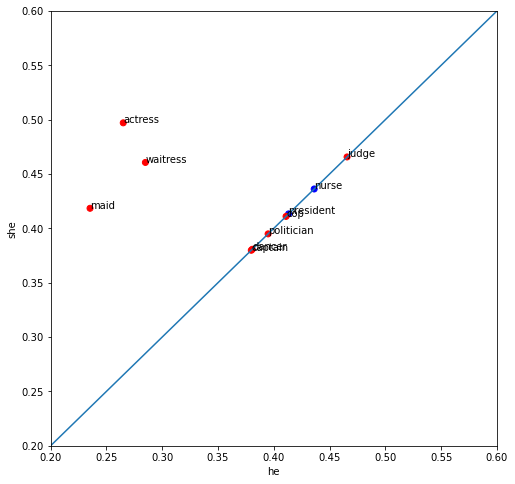

In [27]:
x = new_scatter.he
y = new_scatter.she

plt.figure(figsize=(8,8))
plt.scatter(x, y, c=new_scatter.bias)
plt.xlabel("he")
plt.ylabel("she")
plt.xlim(0.2, 0.6)
plt.ylim(0.2, 0.6)
plt.axline([0,0],[1,1])

for i, txt in enumerate(new_scatter.index):
    plt.annotate(txt, (x[i], y[i]))

In [28]:
debiased_careers = []

for w in career_words:
    debiased_careers.append(linear_projection(glove[w], vB_gender))

In [29]:
debiased_family = []

for w in family_words:
    debiased_family.append(linear_projection(glove[w], vB_gender))

In [30]:
weat_nscore(glove[male_name_words], glove[female_name_words], debiased_careers, debiased_family)

1.372129

# Part 2: Racial Bias

## Step 1:Define Race Direction

Since we cannot necessarily find good word pairs to indicate a direction for other kinds of bias,
we may resort to using names as suggested by Dev(2019).
Different racial groups tend to use certain names more --> reasonable

European American names: Brad, Brendan, Geoffrey, Greg, Brett, Jay, Matthew, Neil, Todd, Allison, Anne, Carrie, Emily, Jill, Laurie, Kristen, Meredith, Sarah

African American names: Darnell, Hakim, Jermaine, Kareem, Jamal, Leroy, Rasheed, Tremayne, Tyrone, Aisha, Ebony, Keisha, Kenya, Latonya, Lakisha, Latoya, Tamika, Tanisha 

In [31]:
EuroAmerName = pd.read_excel("EuroNames.xlsx", names=['name'], header=None)
EuroAmerNameWords = [w for w in EuroAmerName.name if w in glove]
len(EuroAmerNameWords)

18

In [32]:
AfrAmerName = pd.read_excel("AfrNames.xlsx", names=['name'], header=None)
AfrAmerNameWords = [w for w in AfrAmerName.name if w in glove]
len(AfrAmerNameWords)

18

In [33]:
# Determine the bias direction, which encodes the racial difference
v_euro, v_afr, vB_racial = bias_direction(EuroAmerNameWords, AfrAmerNameWords)

## Step 2: Visualization for Racial Bias

In [34]:
# find out 10 most EuroAmer-positive-extreme occupation words 
etemp = []

for x in processed_job_list:
    etemp.append(cos_sim(v_euro, glove[x]))
    
EuroAmer = pd.Series(etemp, index=processed_job_list, name='EuroAmer')
EuroAmer.nlargest(n=10)

author        0.465899
director      0.454183
writer        0.453935
professor     0.412403
actor         0.404513
actress       0.401434
singer        0.400027
journalist    0.390697
reporter      0.385549
artist        0.377582
Name: EuroAmer, dtype: float64

In [35]:
# find out 10 most AfrAmer-positive-extreme occupation words 
atemp = []

for x in processed_job_list:
    atemp.append(cos_sim(v_afr, glove[x]))
    
AfrAmer = pd.Series(atemp, index=processed_job_list, name='AfrAmer')
AfrAmer.nlargest(n=10)

saxophonist      0.285134
singer           0.268677
percussionist    0.267285
socialite        0.266445
harpist          0.243948
quarterback      0.240530
flutist          0.240256
dancer           0.236925
policewoman      0.234511
actress          0.217354
Name: AfrAmer, dtype: float64

In [36]:
dots = list(set(EuroAmer.nlargest(n=10).index) | set(AfrAmer.nlargest(n=10).index))
scatter = pd.concat([EuroAmer,AfrAmer], axis=1).loc[dots]
scatter['bias'] = np.where(scatter.EuroAmer > scatter.AfrAmer, 'blue', 'red')

In [37]:
# To be visually fair and clear, we choose four bias=red and four bias=blue to plot
chosen_job2 = ['policewoman', 'flutist', 'socialite', 'saxophonist', 'author', 'director', 'professor', 'journalist']
scatter=scatter.loc[chosen_job2]

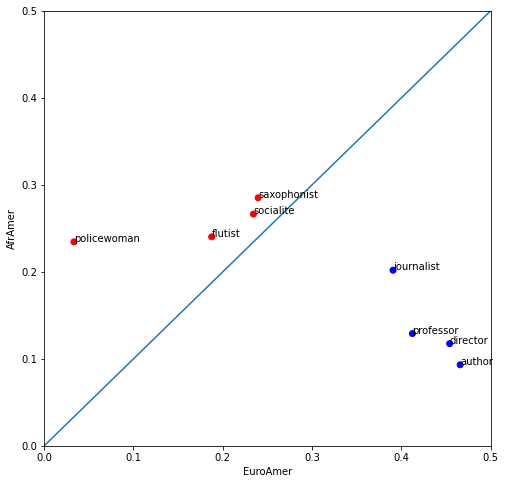

In [38]:
x = scatter.EuroAmer
y = scatter.AfrAmer

plt.figure(figsize=(8,8))
plt.scatter(x, y, c=scatter.bias)
plt.xlabel("EuroAmer")
plt.ylabel("AfrAmer")
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.axline([0,0],[1,1])

for i, txt in enumerate(scatter.index):
    plt.annotate(txt, (x[i], y[i]))

## Step 3: WEAT for Racial Bias

**Target words:**

European American names as defined above

African American names as defined above

**Attrib. words:**

Pleasant: caress, freedom, health, love, peace, cheer, friend, heaven, loyal, pleasure, diamond,
gentle, honest, lucky, rainbow, diploma, gift, honor, miracle, sunrise, family,
happy, laughter, paradise, vacation

Unpleasant: abuse, crash, filth, murder, sickness, accident, death, grief, poison, stink,
assault, disaster, hatred, pollute, tragedy, bomb, divorce, jail, poverty, ugly, cancer, evil,
kill, rotten, vomit


In [39]:
pleasant = pd.read_excel("pleasant.xlsx", names=['ple'], header=None)
pleasant_words = [w for w in pleasant.ple if w in glove]
len(pleasant_words)

25

In [40]:
unpleasant = pd.read_excel("unpleasant.xlsx", names=['unple'], header=None)
unpleasant_words = [w for w in unpleasant.unple if w in glove]
len(unpleasant_words)

25

In [41]:
weat_nscore(glove[EuroAmerNameWords], glove[AfrAmerNameWords], glove[pleasant_words], glove[unpleasant_words])

1.5777843

## Step 4: Debiasing for Race and Repeat Step 2 & 3

In [42]:
debiased_job2 = []

for w in chosen_job2:
    debiased_job2.append(linear_projection(glove[w], vB_racial))

In [43]:
etemp = []

for x in debiased_job2:
    etemp.append(cos_sim(v_euro, x))
    
EuroAmer = pd.Series(etemp, index=chosen_job2, name='EuroAmer')

In [44]:
atemp = []

for x in debiased_job2:
    atemp.append(cos_sim(v_afr, x))

AfrAmer = pd.Series(atemp, index=chosen_job2, name='AfrAmer')

In [45]:
scatter = pd.concat([EuroAmer,AfrAmer], axis=1)
scatter['bias'] = np.where(scatter.EuroAmer > scatter.AfrAmer, 'blue', 'red')
scatter

,EuroAmer,AfrAmer,bias
policewoman,0.136320,0.136320,red
flutist,0.214181,0.214181,blue
socialite,0.250512,0.250512,red
saxophonist,0.262608,0.262608,blue
author,0.298017,0.298017,blue
director,0.300984,0.300984,blue
professor,0.280665,0.280665,blue
journalist,0.300967,0.300967,blue


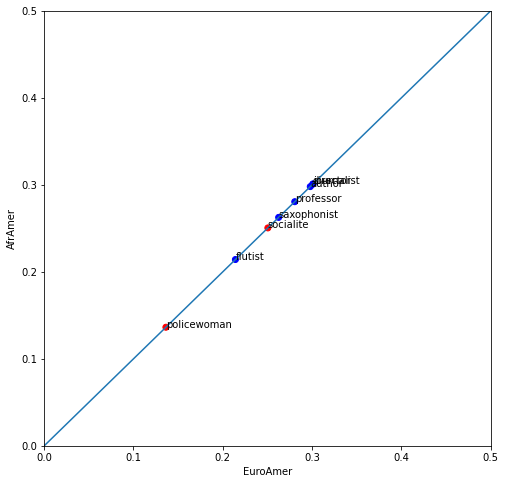

In [46]:
x = scatter.EuroAmer
y = scatter.AfrAmer

plt.figure(figsize=(8,8))
plt.scatter(x, y, c=scatter.bias)
plt.xlabel("EuroAmer")
plt.ylabel("AfrAmer")
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.axline([0,0],[1,1])

for i, txt in enumerate(scatter.index):
    plt.annotate(txt, (x[i], y[i]))

In [47]:
debiased_pleasant = []

for w in pleasant_words:
    debiased_pleasant.append(linear_projection(glove[w], vB_racial))

In [48]:
debiased_unpleasant = []

for w in unpleasant_words:
    debiased_unpleasant.append(linear_projection(glove[w], vB_racial))

In [49]:
weat_nscore(glove[EuroAmerNameWords], glove[AfrAmerNameWords], debiased_pleasant, debiased_unpleasant)

0.08318729